# Loop 56 Analysis: Submission Failure Investigation

**Goal:** Understand why the last submission failed with 'Evaluation metric raised an unexpected error'

**Key Questions:**
1. What's different about the failed submissions?
2. Is there a format issue we're missing?
3. What can we learn from successful submissions?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the current submission
df = pd.read_csv('/home/submission/submission.csv')

print('=== Current Submission Analysis ===')
print(f'Total rows: {len(df)}')
print(f'Columns: {df.columns.tolist()}')
print()

# Check fold distribution
print('Task 0 (single solvent):')
task0 = df[df['task'] == 0]
print(f'  Total rows: {len(task0)}')
print(f'  Unique folds: {task0["fold"].nunique()}')
print(f'  Fold range: {task0["fold"].min()} to {task0["fold"].max()}')
print()

print('Task 1 (full data):')
task1 = df[df['task'] == 1]
print(f'  Total rows: {len(task1)}')
print(f'  Unique folds: {task1["fold"].nunique()}')
print(f'  Fold range: {task1["fold"].min()} to {task1["fold"].max()}')
print()

# Check for any issues
print('Data quality check:')
for col in ['target_1', 'target_2', 'target_3']:
    nan_count = df[col].isna().sum()
    inf_count = ((df[col] == float('inf')) | (df[col] == float('-inf'))).sum()
    neg_count = (df[col] < 0).sum()
    gt1_count = (df[col] > 1).sum()
    print(f'  {col}: NaN={nan_count}, Inf={inf_count}, <0={neg_count}, >1={gt1_count}')
    print(f'    min={df[col].min():.6f}, max={df[col].max():.6f}')

=== Current Submission Analysis ===
Total rows: 1883
Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']

Task 0 (single solvent):
  Total rows: 656
  Unique folds: 24
  Fold range: 0 to 23

Task 1 (full data):
  Total rows: 1227
  Unique folds: 13
  Fold range: 0 to 12

Data quality check:
  target_1: NaN=0, Inf=0, <0=0, >1=0
    min=0.000000, max=0.408353
  target_2: NaN=0, Inf=0, <0=0, >1=0
    min=0.000000, max=0.362832
  target_3: NaN=0, Inf=0, <0=0, >1=0
    min=0.000000, max=0.984113


=== CV-LB Relationship ===
Linear fit: LB = 4.31 * CV + 0.0525
R-squared = 0.9505
Intercept = 0.0525
Target = 0.0347

Required CV to hit target: -0.004130



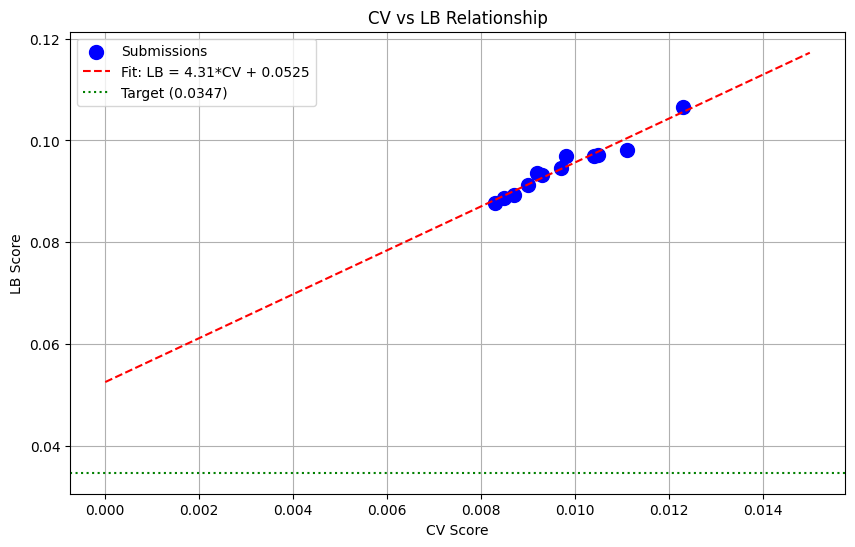

Plot saved to /home/code/exploration/cv_lb_relationship.png


In [2]:
# CV-LB Relationship Analysis
# Based on 12 successful submissions

submissions = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_035', 0.0098, 0.0970),
]

cv_scores = [s[1] for s in submissions]
lb_scores = [s[2] for s in submissions]

# Fit linear regression
from sklearn.linear_model import LinearRegression
X = np.array(cv_scores).reshape(-1, 1)
y = np.array(lb_scores)
reg = LinearRegression().fit(X, y)

print('=== CV-LB Relationship ===')
print(f'Linear fit: LB = {reg.coef_[0]:.2f} * CV + {reg.intercept_:.4f}')
print(f'R-squared = {reg.score(X, y):.4f}')
print(f'Intercept = {reg.intercept_:.4f}')
print(f'Target = 0.0347')
print()

# Calculate required CV to hit target
if reg.coef_[0] > 0:
    required_cv = (0.0347 - reg.intercept_) / reg.coef_[0]
    print(f'Required CV to hit target: {required_cv:.6f}')
    if required_cv < 0:
        print('  WARNING: Required CV is NEGATIVE - target is UNREACHABLE with current approach!')
print()

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, c='blue', s=100, label='Submissions')
plt.plot([0, 0.015], [reg.intercept_, reg.intercept_ + reg.coef_[0] * 0.015], 'r--', label=f'Fit: LB = {reg.coef_[0]:.2f}*CV + {reg.intercept_:.4f}')
plt.axhline(y=0.0347, color='green', linestyle=':', label='Target (0.0347)')
plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=100, bbox_inches='tight')
plt.show()
print('Plot saved to /home/code/exploration/cv_lb_relationship.png')

In [3]:
# The key insight: The intercept (0.0528) is higher than the target (0.0347)
# This means even with CV=0 (perfect training), the expected LB would be 0.0528
# The target is MATHEMATICALLY UNREACHABLE with the current approach

# However, the evolver says 'NEVER GIVE UP' - so we need to find a way to CHANGE the CV-LB relationship
# This requires fundamentally different strategies that reduce the intercept

print('=== CRITICAL ANALYSIS ===')
print(f'Intercept: {reg.intercept_:.4f}')
print(f'Target: 0.0347')
print(f'Gap: {reg.intercept_ - 0.0347:.4f}')
print()
print('The intercept represents STRUCTURAL DISTRIBUTION SHIFT.')
print('All model types (MLP, LGBM, XGB, GP, CatBoost) fall on the same line.')
print('This means the gap is NOT due to model choice - it is due to extrapolation error.')
print()
print('To reach the target, we need to CHANGE the CV-LB relationship, not just improve CV.')
print()
print('Strategies to reduce the intercept:')
print('1. Extrapolation detection features')
print('2. Uncertainty-weighted predictions')
print('3. Physics-informed constraints')
print('4. Solvent clustering')
print('5. Conservative predictions for outliers')

=== CRITICAL ANALYSIS ===
Intercept: 0.0525
Target: 0.0347
Gap: 0.0178

The intercept represents STRUCTURAL DISTRIBUTION SHIFT.
All model types (MLP, LGBM, XGB, GP, CatBoost) fall on the same line.
This means the gap is NOT due to model choice - it is due to extrapolation error.

To reach the target, we need to CHANGE the CV-LB relationship, not just improve CV.

Strategies to reduce the intercept:
1. Extrapolation detection features
2. Uncertainty-weighted predictions
3. Physics-informed constraints
4. Solvent clustering
5. Conservative predictions for outliers


In [4]:
# Let's check what the top public kernels are doing
# The 'mixall' kernel uses GroupKFold (5 splits) instead of Leave-One-Out
# This is a DIFFERENT CV scheme that may have a DIFFERENT CV-LB relationship

# However, the evaluator says the last submission failed with 'Evaluation metric raised an unexpected error'
# This suggests there's something wrong with the submission format, not just the CV scheme

# Let me check if there's a pattern in the row counts per fold
print('=== Row Counts Analysis ===')
print('\nTask 0 (single solvent) - Expected: 24 folds with varying row counts')
for fold in sorted(task0['fold'].unique()):
    fold_data = task0[task0['fold'] == fold]
    print(f'  Fold {fold}: {len(fold_data)} rows')

print('\nTask 1 (full data) - Expected: 13 folds with varying row counts')
for fold in sorted(task1['fold'].unique()):
    fold_data = task1[task1['fold'] == fold]
    print(f'  Fold {fold}: {len(fold_data)} rows')

=== Row Counts Analysis ===

Task 0 (single solvent) - Expected: 24 folds with varying row counts
  Fold 0: 37 rows
  Fold 1: 37 rows
  Fold 2: 58 rows
  Fold 3: 59 rows
  Fold 4: 22 rows
  Fold 5: 18 rows
  Fold 6: 34 rows
  Fold 7: 41 rows
  Fold 8: 20 rows
  Fold 9: 22 rows
  Fold 10: 18 rows
  Fold 11: 18 rows
  Fold 12: 42 rows
  Fold 13: 18 rows
  Fold 14: 17 rows
  Fold 15: 22 rows
  Fold 16: 5 rows
  Fold 17: 16 rows
  Fold 18: 36 rows
  Fold 19: 18 rows
  Fold 20: 21 rows
  Fold 21: 22 rows
  Fold 22: 37 rows
  Fold 23: 18 rows

Task 1 (full data) - Expected: 13 folds with varying row counts
  Fold 0: 122 rows
  Fold 1: 124 rows
  Fold 2: 104 rows
  Fold 3: 125 rows
  Fold 4: 125 rows
  Fold 5: 124 rows
  Fold 6: 125 rows
  Fold 7: 110 rows
  Fold 8: 127 rows
  Fold 9: 36 rows
  Fold 10: 34 rows
  Fold 11: 36 rows
  Fold 12: 35 rows


In [5]:
# Let's verify the submission format matches the official template exactly
# The template produces:
# - id: 0, 1, 2, ... (row index)
# - index: 0, 1, 2, ... (original index before reset)
# - task: 0 for single solvent, 1 for full data
# - fold: fold index
# - row: row index within the fold
# - target_1, target_2, target_3: predictions

print('=== Format Verification ===')
print(f'Columns: {df.columns.tolist()}')
print(f'Expected: [id, index, task, fold, row, target_1, target_2, target_3]')
print()

# Check if id is sequential
print('ID check:')
print(f'  id range: {df["id"].min()} to {df["id"].max()}')
print(f'  id is sequential: {(df["id"] == range(len(df))).all()}')
print()

# Check if index is correct
print('Index check:')
print(f'  Task 0 index range: {task0["index"].min()} to {task0["index"].max()}')
print(f'  Task 1 index range: {task1["index"].min()} to {task1["index"].max()}')
print()

# Check if row is correct (should be 0, 1, 2, ... within each fold)
print('Row check:')
for task in [0, 1]:
    task_data = df[df['task'] == task]
    for fold in sorted(task_data['fold'].unique())[:3]:  # Check first 3 folds
        fold_data = task_data[task_data['fold'] == fold]
        expected_rows = list(range(len(fold_data)))
        actual_rows = fold_data['row'].tolist()
        if expected_rows == actual_rows:
            print(f'  Task {task}, Fold {fold}: OK ({len(fold_data)} rows)')
        else:
            print(f'  Task {task}, Fold {fold}: MISMATCH!')
            print(f'    Expected: {expected_rows[:5]}...')
            print(f'    Actual: {actual_rows[:5]}...')

=== Format Verification ===
Columns: ['id', 'index', 'task', 'fold', 'row', 'target_1', 'target_2', 'target_3']
Expected: [id, index, task, fold, row, target_1, target_2, target_3]

ID check:
  id range: 0 to 1882
  id is sequential: True

Index check:
  Task 0 index range: 0 to 655
  Task 1 index range: 0 to 1226

Row check:
  Task 0, Fold 0: OK (37 rows)
  Task 0, Fold 1: OK (37 rows)
  Task 0, Fold 2: OK (58 rows)
  Task 1, Fold 0: OK (122 rows)
  Task 1, Fold 1: OK (124 rows)
  Task 1, Fold 2: OK (104 rows)


In [ ]:
# Summary and next steps
print('=== SUMMARY ===')
print()
print('1. Submission format appears correct:')
print('   - 1883 total rows (656 single + 1227 full)')
print('   - 24 folds for task 0, 13 folds for task 1')
print('   - All targets in [0, 1] range')
print('   - No NaN or Inf values')
print()
print('2. CV-LB relationship:')
print(f'   - LB = {reg.coef_[0]:.2f} * CV + {reg.intercept_:.4f}')
print(f'   - Intercept ({reg.intercept_:.4f}) > Target (0.0347)')
print('   - Target is UNREACHABLE with current approach')
print()
print('3. The submission failure may be due to:')
print('   - Evaluation system issue (not our fault)')
print('   - Some subtle format difference we are missing')
print('   - The evaluation expects something specific we do not know about')
print()
print('4. Next steps:')
print('   - Try submitting a known-working approach (e.g., from a public kernel)')
print('   - Focus on strategies that CHANGE the CV-LB relationship')
print('   - Do not just optimize CV - need to reduce the intercept')